In [1]:
import os
import sys
sys.path.append('../')
os.chdir('../')

from utilidades import *
import matplotlib
from matplotlib import pyplot

In [2]:
local_data = load_data(aggregate=False)
local_data_index = pd.MultiIndex.from_product(
    [local_data.keys(), ['active_cases', 'cases', 'death', 'recovered', 'pending', 'discarded']]
)

local_data = pd.DataFrame(it.chain(*local_data.values())).T
local_data.columns = local_data_index

In [3]:
def get_df(data, key):
    data = data.loc[pd.IndexSlice[:],pd.IndexSlice[:, key]].copy()
    data.columns = data.columns.droplevel(1)
    return data
           
local_cases = get_df(local_data, 'cases')
local_deaths = get_df(local_data, 'death')
local_pending = get_df(local_data, 'pending')
local_discarded = get_df(local_data, 'discarded')

local_new_cases = local_cases.diff()
local_new_cases[local_new_cases < 0] = 0

# case fatality rate
cfr = local_deaths / local_cases
cfr[cfr == 0] = np.nan
cfr = cfr.rolling(window=7).mean()

local_tests = local_discarded + local_cases
local_daily_tests = local_tests.diff()
local_daily_tests[local_daily_tests < local_new_cases] = local_new_cases[
    local_daily_tests < local_new_cases
]
local_daily_tests[local_daily_tests < 1] = 1

# prevalence^-1
test_case_ratio = local_daily_tests / local_new_cases
test_case_ratio[test_case_ratio < 1] = 1
test_case_ratio[test_case_ratio > 10] = 10

local_pending = local_pending
local_pending_capacity_ratio = (local_daily_tests + local_pending) / local_daily_tests

test_case_ratio = 1 / test_case_ratio
local_pending_capacity_ratio = 1 - 1 / local_pending_capacity_ratio

No handles with labels found to put in legend.


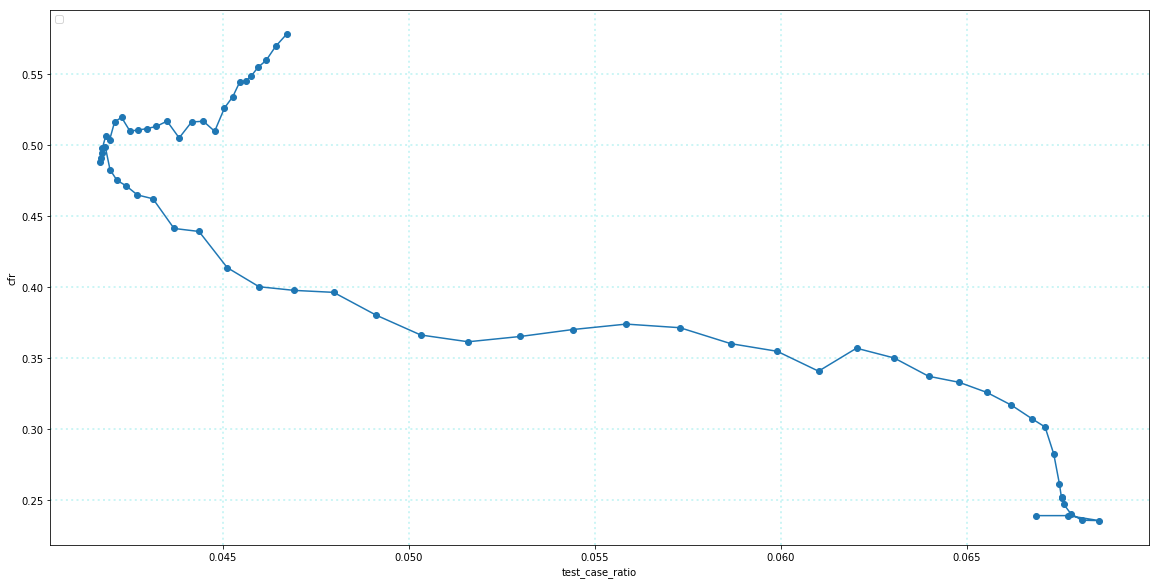

In [4]:
WINDOW_SIZE = 14
def stylize_ax(ax):
    if type(ax) == np.ndarray:
        [stylize_ax(_) for _ in ax]
        return
    
    ax.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    ax.legend(loc='upper left')
    ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    
# ax = cfr.mean(axis=1).plot(label='cfr')
# ax = test_case_ratio.mean(axis=1).plot(label='sample prevalence')
# ax = local_pending_capacity_ratio.mean(axis=1).plot(label='pending tests')
# stylize_ax(ax)

fig, ax = pyplot.subplots()
ax.plot(
    cfr.mean(axis=1).rolling(window=WINDOW_SIZE).mean(), 
    test_case_ratio.mean(axis=1).rolling(window=WINDOW_SIZE).mean(), 
    marker='o'
)
ax.set_xlabel('test_case_ratio')
ax.set_ylabel('cfr')
stylize_ax(ax)

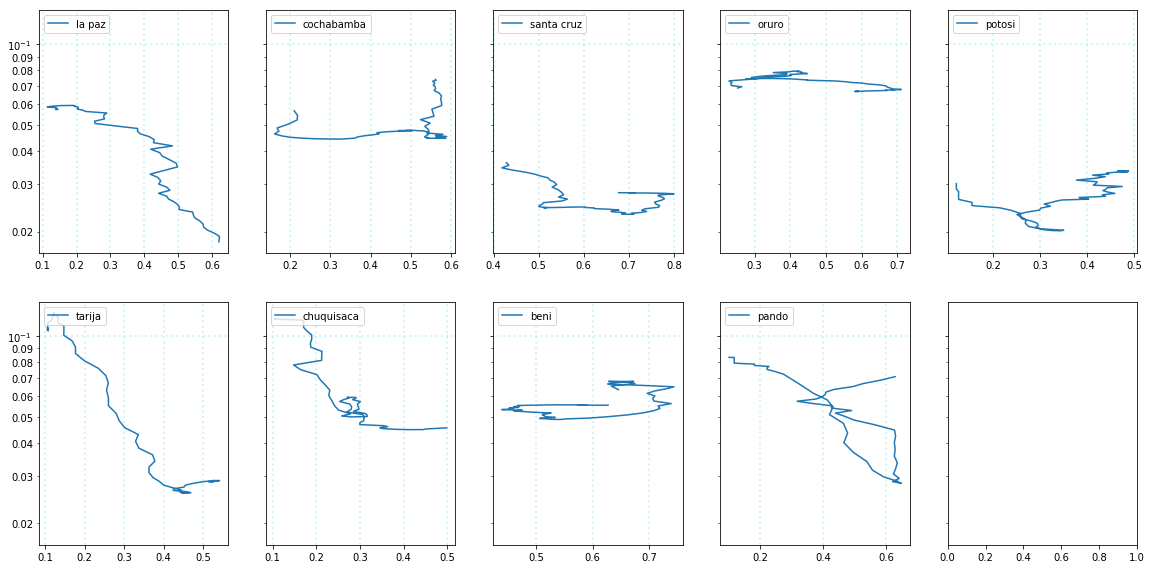

In [5]:
def subplots(data_x, data_y, logy=True):
    fig, axs = pyplot.subplots(ncols=5, nrows=2, sharey=True)
    faxs = axs.flatten()
 
    for idx, key in enumerate(data_x.columns):
        local_data_x = data_x[key]
        local_data_y = data_y[key]
        faxs[idx].plot(local_data_x, local_data_y, label=key)
        if logy:
            faxs[idx].set_yscale('log')
        stylize_ax(faxs[idx])
        
subplots(
    test_case_ratio.rolling(window=WINDOW_SIZE).mean(), 
    cfr.rolling(window=WINDOW_SIZE).mean()
)

No handles with labels found to put in legend.


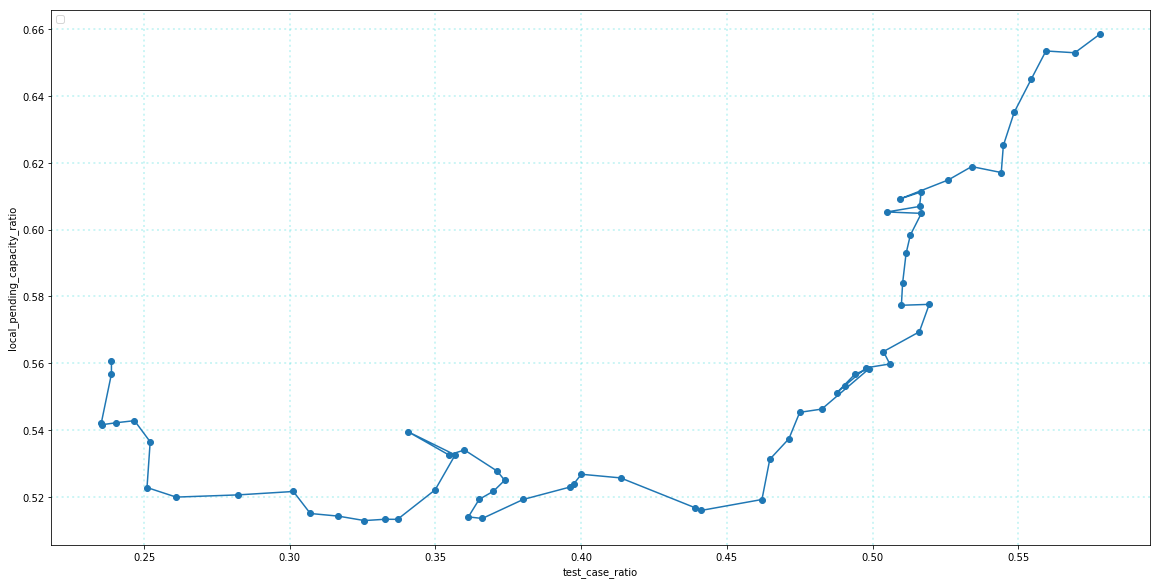

In [6]:
fig, ax = pyplot.subplots()
ax.plot(
    test_case_ratio.mean(axis=1).rolling(window=WINDOW_SIZE).mean(), 
    local_pending_capacity_ratio.mean(axis=1).rolling(window=WINDOW_SIZE).mean(), 
    marker='o'
)
ax.set_xlabel('test_case_ratio')
ax.set_ylabel('local_pending_capacity_ratio')
stylize_ax(ax)

# fig, ax = pyplot.subplots()
# ax.plot(local_pending_capacity_ratio.mean(axis=1), cfr.mean(axis=1), marker='o')
# # stylize_ax(ax)

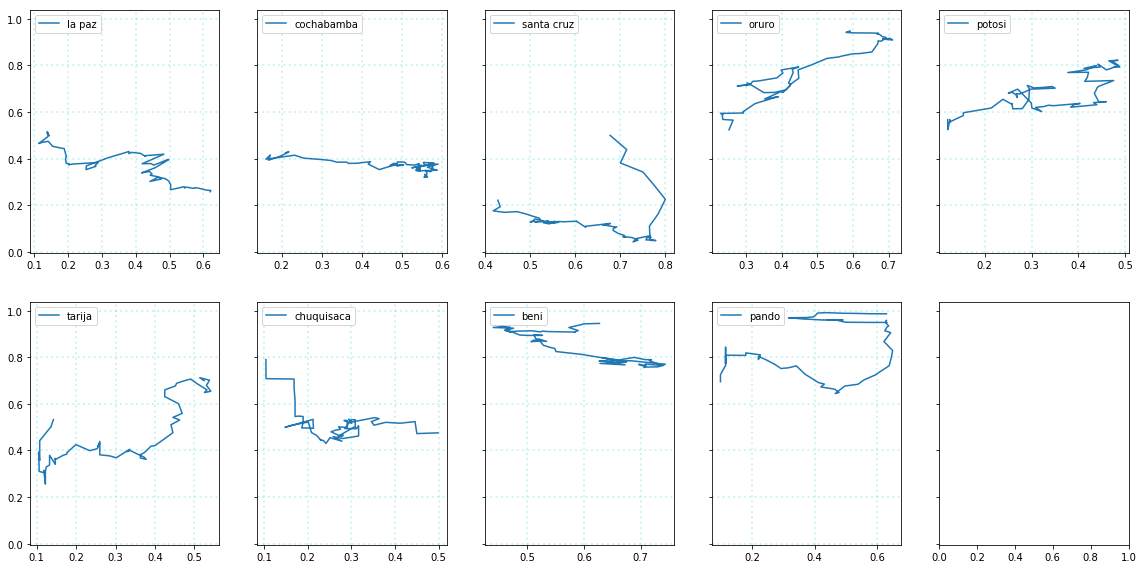

In [7]:
subplots(
    test_case_ratio.rolling(window=WINDOW_SIZE).mean(), 
    local_pending_capacity_ratio.rolling(window=WINDOW_SIZE).mean(), 
    logy=False
)

No handles with labels found to put in legend.


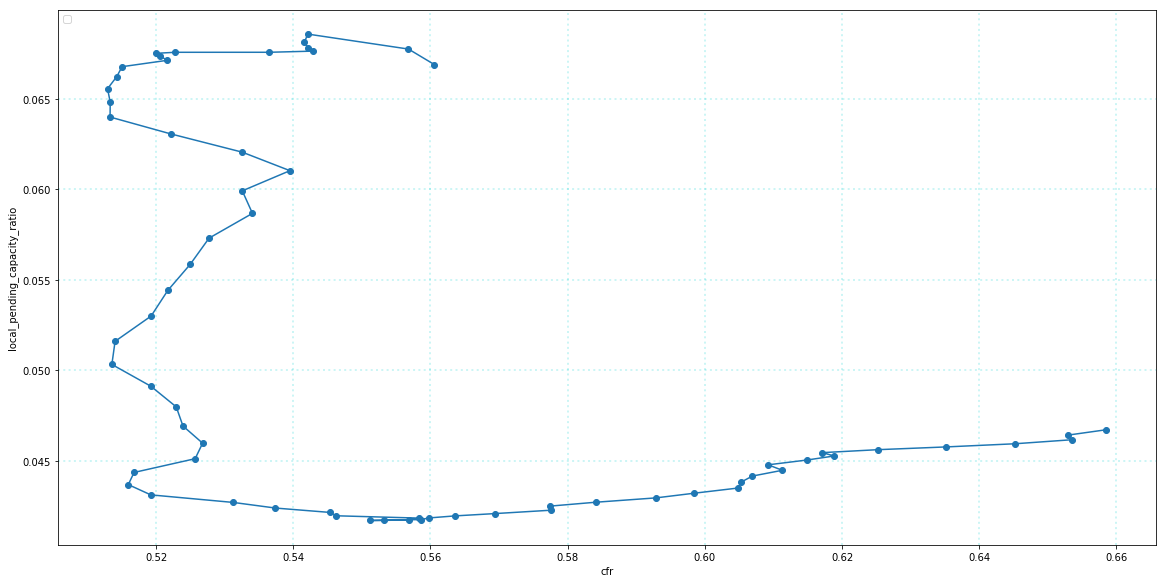

In [8]:
fig, ax = pyplot.subplots()
ax.plot(
    local_pending_capacity_ratio.mean(axis=1).rolling(window=WINDOW_SIZE).mean(), 
    cfr.mean(axis=1).rolling(window=WINDOW_SIZE).mean(), 
    marker='o'
)
ax.set_xlabel('cfr')
ax.set_ylabel('local_pending_capacity_ratio')
stylize_ax(ax)

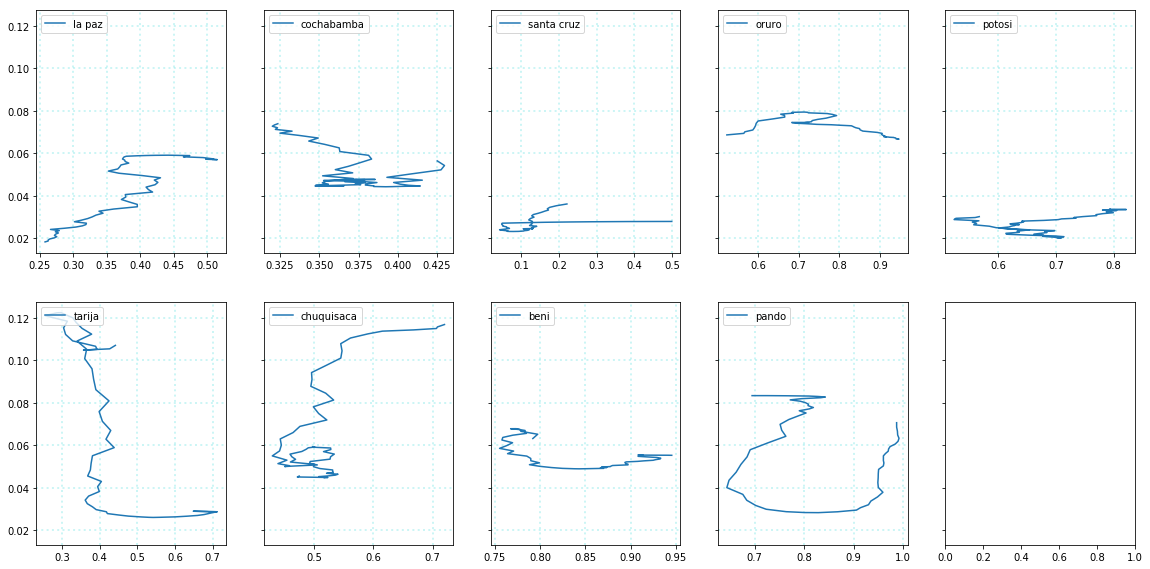

In [9]:
subplots(
    local_pending_capacity_ratio.rolling(window=WINDOW_SIZE).mean(), 
    cfr.rolling(window=WINDOW_SIZE).mean(), 
    logy=False
)